Downloads :

In [30]:
!pip install kagglehub

Import :

In [63]:
import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
from IPython.display import Image

import pandas as pd

In [32]:


# Download latest version
path = kagglehub.dataset_download("rhtsingh/google-universal-image-embeddings-128x128")

print("Path to dataset files:", path)

100%|██████████| 1.36G/1.36G [00:18<00:00, 77.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rhtsingh/google-universal-image-embeddings-128x128/versions/1


In [33]:
shutil.move(path,"./")

'./1'

In [34]:

# Chemin du dossier d'entrée contenant les images
input_dir = "./1/128x128"
output_dir = "dataset"

# Proportions pour train, val et test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Vérification que les proportions totalisent 1
assert train_ratio + val_ratio + test_ratio == 1, "Les proportions doivent totaliser 1."

# Récupérer toutes les images de tous les sous-dossiers
images = []
for root, _, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            images.append(os.path.join(root, file))

# Mélanger et diviser les images en train, val et test
train_images, temp_images = train_test_split(images, test_size=(1 - train_ratio), random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=test_ratio / (test_ratio + val_ratio), random_state=42)

# Fonction pour copier les images dans les répertoires de sortie
def copy_images(image_list, output_subdir):
    output_path = os.path.join(output_dir, output_subdir)
    os.makedirs(output_path, exist_ok=True)
    for image_path in image_list:
        shutil.copy(image_path, os.path.join(output_path, os.path.basename(image_path)))

# Copier les images dans les répertoires train, val et test
copy_images(train_images, "train/train_HR")
copy_images(val_images, "val/val_HR")
copy_images(test_images, "test/test_HR")

print("Séparation des datasets terminée avec succès !")


Séparation des datasets terminée avec succès !


In [35]:
print(f"Nombre d'images dans l'ensemble train : {len(train_images)}")
print(f"Nombre d'images dans l'ensemble validation : {len(val_images)}")
print(f"Nombre d'images dans l'ensemble test : {len(test_images)}")

Nombre d'images dans l'ensemble train : 92769
Nombre d'images dans l'ensemble validation : 19879
Nombre d'images dans l'ensemble test : 19880


In [49]:
import os
import cv2

def downscaleImage(input_path, output_path, scale=3, kernel_size=3):

    # Vérifier si le dossier de sortie existe, sinon le créer
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Liste tous les fichiers dans le dossier d'entrée
    for filename in os.listdir(input_path):
        # Crée le chemin complet du fichier
        input_image_path = os.path.join(input_path, filename)

        # Vérifie que c'est un fichier image (extensions .jpg, .jpeg, .png, etc.)
        if os.path.isfile(input_image_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            # Charger l'image haute résolution (HR)
            img_hr = cv2.imread(input_image_path)

            # Vérifier que l'image a été correctement chargée
            if img_hr is None:
                print(f"Erreur lors du chargement de l'image : {input_image_path}")
                continue

            # Appliquer un flou gaussien à l'image
            img_blurred = cv2.GaussianBlur(img_hr, (kernel_size, kernel_size), 0)

            # Récupérer la taille originale de l'image
            height, width = img_hr.shape[:2]

            # Sous-échantillonner l'image par un facteur de downscaling
            lr_img = cv2.resize(img_blurred, (width // scale, height // scale), interpolation=cv2.INTER_CUBIC)

            # Rééchantillonner à la taille d'origine en utilisant l'interpolation bicubique
            lr_img = cv2.resize(lr_img, (width, height), interpolation=cv2.INTER_CUBIC)

            # Créer le chemin pour sauvegarder l'image downscalée dans le dossier de sortie
            output_image_path = os.path.join(output_path, filename)

            # Sauvegarder l'image basse résolution (LR) dans le dossier de sortie
            cv2.imwrite(output_image_path, lr_img)


In [50]:
input_directory = "/content/dataset/test/test_HR"
output_directory = "/content/dataset/test/test_LR"
downscaleImage(input_directory, output_directory, scale=3, kernel_size=5)

In [51]:
input_directory = "/content/dataset/train/train_HR"
output_directory = "/content/dataset/train/train_LR"
downscaleImage(input_directory, output_directory, scale=3, kernel_size=5)

In [52]:
input_directory = "/content/dataset/val/val_HR"
output_directory = "/content/dataset/val/val_LR"
downscaleImage(input_directory, output_directory, scale=3, kernel_size=5)

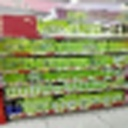

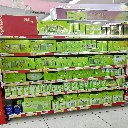

In [61]:

# Assuming your image datasets are in the specified directories
train_hr_dir = "/content/dataset/train/train_HR"
train_lr_dir = "/content/dataset/train/train_LR"

# Function to display a random image pair
def display_random_image_pair():
    hr_images = [f for f in os.listdir(train_hr_dir) if os.path.isfile(os.path.join(train_hr_dir, f))]
    if not hr_images:
        print("No images found in the high-resolution directory.")
        return

    random_image = random.choice(hr_images)
    hr_path = os.path.join(train_hr_dir, random_image)
    lr_path = os.path.join(train_lr_dir, random_image)


    if os.path.exists(hr_path) and os.path.exists(lr_path):
        display(Image(filename=lr_path, width=256))
        display(Image(filename=hr_path, width=256))
    else:
        print(f"Could not find corresponding low/high res images for {random_image}")

# Call the function to display the image pair
display_random_image_pair()

In [77]:


def create_image_dataframe(directory):
    image_data = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            filepath = os.path.join(directory, filename)
            try:
                img = cv2.imread(filepath)
                if img is not None:
                    image_data.append([filename, img])
            except Exception as e:
                print(f"Error reading image {filename}: {e}")
    df = pd.DataFrame(image_data, columns=['image_name', 'image'])
    return df




In [78]:

train_hr_df = create_image_dataframe("/content/dataset/train/train_HR")
print(train_hr_df.head())

train_lr_df = create_image_dataframe("/content/dataset/train/train_LR")
print(train_lr_df.head())


       image_name                                              image
0  image30811.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1  image17732.jpg  [[[62, 108, 142], [57, 104, 136], [64, 109, 14...
2   image3778.png  [[[157, 162, 160], [154, 160, 158], [152, 156,...
3  image13618.jpg  [[[163, 157, 158], [150, 144, 145], [146, 138,...
4  image30480.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
       image_name                                              image
0  image30811.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
1  image17732.jpg  [[[58, 108, 138], [58, 108, 138], [58, 106, 13...
2   image3778.png  [[[198, 201, 199], [198, 201, 199], [198, 201,...
3  image13618.jpg  [[[166, 154, 152], [165, 153, 151], [162, 151,...
4  image30480.jpg  [[[253, 255, 255], [253, 255, 255], [255, 255,...


In [79]:

test_hr_df = create_image_dataframe("/content/dataset/test/test_HR")
print(test_hr_df.head())

test_lr_df = create_image_dataframe("/content/dataset/test/test_LR")
print(test_lr_df.head())

       image_name                                              image
0   image1556.png  [[[128, 128, 128], [128, 128, 128], [128, 128,...
1  image30652.jpg  [[[232, 210, 198], [229, 209, 198], [246, 227,...
2  image30480.jpg  [[[21, 31, 25], [18, 28, 22], [18, 30, 24], [2...
3   image7303.jpg  [[[113, 112, 108], [113, 112, 108], [118, 117,...
4   image9187.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
       image_name                                              image
0   image1556.png  [[[128, 128, 128], [128, 128, 128], [128, 128,...
1  image30652.jpg  [[[221, 201, 190], [223, 205, 194], [230, 212,...
2  image30480.jpg  [[[56, 66, 60], [54, 66, 60], [53, 65, 59], [4...
3   image7303.jpg  [[[115, 114, 110], [116, 115, 111], [116, 115,...
4   image9187.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...


In [80]:

val_hr_df = create_image_dataframe("/content/dataset/val/val_HR")
print(val_hr_df.head())

val_lr_df = create_image_dataframe("/content/dataset/val/val_LR")
print(val_lr_df.head())

       image_name                                              image
0  image30811.jpg  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...
1   image4246.png  [[[128, 128, 128], [128, 128, 128], [128, 128,...
2   image3900.jpg  [[[8, 12, 13], [9, 13, 14], [10, 14, 15], [10,...
3  image29717.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
4  image7686.jpeg  [[[199, 197, 196], [202, 200, 199], [200, 198,...
       image_name                                              image
0  image30811.jpg  [[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ...
1   image4246.png  [[[128, 128, 128], [128, 128, 128], [128, 128,...
2   image3900.jpg  [[[10, 12, 13], [11, 13, 14], [12, 14, 15], [1...
3  image29717.jpg  [[[255, 255, 255], [255, 255, 255], [255, 255,...
4  image7686.jpeg  [[[200, 198, 197], [200, 198, 197], [201, 199,...


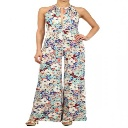

In [81]:

def display_random_image_from_df(df):
    if df.empty:
        print("DataFrame is empty. No images to display.")
        return

    random_index = random.randint(0, len(df) - 1)
    random_row = df.iloc[random_index]
    image_name = random_row['image_name']
    image_array = random_row['image']

    # Convert the image array to a displayable format (e.g., using OpenCV)
    from PIL import Image
    image = Image.fromarray(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
    display(image)

# Example usage (replace with your actual DataFrame):
display_random_image_from_df(train_hr_df)

In [82]:
train_hr_df.to_csv("train_hr_df.csv", index=False)
train_lr_df.to_csv("train_lr_df.csv", index=False)

test_hr_df.to_csv("test_hr_df.csv", index=False)
test_lr_df.to_csv("test_lr_df.csv", index=False)

val_hr_df.to_csv("val_hr_df.csv", index=False)
val_lr_df.to_csv("val_lr_df.csv", index=False)